In [11]:
import pandas as pd
import ast
from pickle import load
import pickle

In [5]:
#pip install pyupset
import pyupset as pyu
from upsetplot import generate_counts, plot
from matplotlib import pyplot as plt


# Abstract level CT annotation and evaluation

In [21]:
prompt_version_to_evaluate = "v1"
df_conditions = pd.read_csv(f"./evaluations/evaluated_ct_level_conditions_gpt_prompt_{prompt_version_to_evaluate}.csv")
df_drugs = pd.read_csv(f"./evaluations/evaluated_ct_level_drugs_gpt_prompt_{prompt_version_to_evaluate}.csv")


In [122]:
def check_match(row, column, target_col='canonical_unique_conditions'):
    cell = row[column]
    if pd.isna(cell):
        return False  # If cell is NaN, return False immediately
    conditions = set(str(cell).split('|'))
    return row[target_col] in conditions
    
   
def check_partial_match(row, column, target_col='canonical_unique_conditions'):
    target_words = row[target_col].lower().split()
    predictions = row[column]
    
    if pd.isna(predictions):
        return False
        
    predictions = predictions.lower().split('|')
    matching_count = 0

    for prediction_string in predictions:
        prediction_words = prediction_string.split()
        #print(target_words, prediction_words)
        common_words = set(target_words) & set(prediction_words)
        #print(common_words)
        # Check if more than half of the target words overlap
        if len(common_words) >= len(target_words) / 2:
            matching_count += 1

    return matching_count > 0 

## Conditions

In [123]:
df_conditions

,Unnamed: 0,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions,eval_exact_match_bert-base-uncased,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,0,NCT04849741,alexander disease|axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease|gross motor function,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}",...,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,1,NCT04576507,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|abuse|experimental pain,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...,"{'p': 0.5, 'r': 1.0, 'f1': 0.67}",...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.29, 'r': 1.0, 'f1': 0.44}","{'tp': 2, 'fp': 5, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}"
2,2,NCT00261508,pervasive developmental disorders|autistic dis...,asperger syndrome|autistic disorder|dcild deve...,per|pervasive developmental disorders|autistic...,pervasive developmental disorders|autistic dis...,pervasive developmental disorders|autistic dis...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 0.2, 'r': 0.5, 'f1': 0.29}","{'tp': 1, 'fp': 4, 'fn': 1}"
3,3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,radiculopathy|sciatica,pain,pain|lumbosacral radicular pain|lumbosacral ra...,pain|lumbosacral radicular pain|lumbosacral ra...,lumbosacral radiculopathy|radicular pain,lumbosacral radiculopathy|radicular pain,"{'p': 0.0, 'r': 0.0, 'f1': 0}",...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 2, 'fn': 2}"
4,4,NCT03150563,NaN,"contracture of muscle, thigh|muscle rigidity|s...",NaN,NaN,NaN,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 3, 'fn': 1}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,NCT03755362,mild cognitive impairment|moderate cognitive i...,carotid stenosis|mild cognitive impairment|per...,mild cognitive impairment|moderate cognitive i...,mild cognitive impairment|moderate cognitive i...,mild cognitive impairment|moderate cognitive i...,periodontitis|dementia|mild cognitive impairme...,periodontitis|dementia|asymptomatic carotid ar...,"{'p': 0.75, 'r': 1.0, 'f1': 0.86}",...,"{'p': 0.8

In [158]:
df_conditions_to_eval = df_conditions[['nct_id','canonical_unique_conditions', 'canonical_aact_conditions', 'canonical_BioLinkBERT-base_conditions', 'canonical_biobert-v1.1_conditions','canonical_gpt-4_conditions']]
# Split the first column by '|'
df_conditions_to_eval['canonical_unique_conditions'] = df_conditions_to_eval['canonical_unique_conditions'].str.split('|')

# Explode the DataFrame based on the first column
df_exploded = df_conditions_to_eval.explode('canonical_unique_conditions')
df_exploded = df_exploded.dropna(subset=['canonical_unique_conditions'])

df_exploded

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_77952/1436948201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions_to_eval['canonical_unique_conditions'] = df_conditions_to_eval['canonical_unique_conditions'].str.split('|')


,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions
0,NCT04849741,alexander disease,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|gross motor function
0,NCT04849741,axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|gross motor function
1,NCT04576507,chronic pain,cannabis|hyperalgesia|pain|tolerance,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic effec...
1,NCT04576507,pain,cannabis|hyperalgesia|pain|tolerance,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic effec...
2,NCT00261508,pervasive developmental disorders,asperger syndrome|autistic disorder|dcild deve...,pervasive developmental disorders|autistic dis...,pervasive developmental disorders|autistic dis...,autistic disorder|pervasive developmental diso...
...,...,...,...,...,...,...
86,NCT00506415,mild to moderate alzheimer's disease,alzheimer disease,mild to moderate alzheimer's disease|alzheimer...,mild to moderate alzheimer's disease|alzheimer...,alzheimer disease|functional decline|cognitive...
86,NCT00506415,alzheimer disease,alzheimer disease,mild to moderate alzheimer's disease|alzheimer...,mild to moderate alzheimer's disease|alzheimer...,alzheimer disease|functional decline|cognitive...
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,known or suspected vascular disease of the su|...,vascular disease of the supra-aortic vessels
88,NCT04184206,major depressive disorder,"attention training|depression|symptoms, affect...",major depressive disorder|depression,major depressive disorder|depression,major depressive disorder|symptoms


In [159]:
# Apply the function to create new columns
df_exploded['is_in_AACT_partial'] = df_exploded.apply(check_partial_match, column='canonical_aact_conditions', axis=1)
df_exploded['is_in_BioLinkBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_BioLinkBERT-base_conditions', axis=1)
df_exploded['is_in_BioBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_biobert-v1.1_conditions', axis=1)
df_exploded['is_in_gpt-4_partial'] = df_exploded.apply(check_partial_match, column='canonical_gpt-4_conditions', axis=1)

# Apply the function to create new columns
df_exploded['is_in_AACT'] = df_exploded.apply(check_match, column='canonical_aact_conditions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_conditions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_conditions', axis=1)
df_exploded['is_in_BioBERT'] = df_exploded.apply(check_match, column='canonical_biobert-v1.1_conditions', axis=1)
df_exploded['is_in_gpt-4'] = df_exploded.apply(check_match, column='canonical_gpt-4_conditions', axis=1)

df_exploded

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
0,NCT04849741,alexander disease,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|gross motor function,True,True,True,True,True,True,True,True
0,NCT04849741,axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|gross motor function,False,False,False,False,False,False,False,False
1,NCT04576507,chronic pain,cannabis|hyperalgesia|pain|tolerance,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic effec...,True,True,True,True,False,True,True,True
1,NCT04576507,pain,cannabis|hyperalgesia|pain|tolerance,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic effec...,True,True,True,True,True,True,True,True
2,NCT00261508,pervasive developmental disorders,asperger syndrome|autistic disorder|dcild deve...,pervasive developmental disorders|autistic dis...,pervasive developmental disorders|autistic dis...,autistic disorder|pervasive developmental diso...,False,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,NCT00506415,mild to moderate alzheimer's disease,alzheimer disease,mild to moderate alzheimer's disease|alzheimer...,mild to moderate alzheimer's disease|alzheimer...,alzheimer disease|functional decline|cognitive...,False,True,True,False,False,True,True,False
86,NCT00506415,alzheimer disease,alzheimer disease,mild to moderate alzheimer's disease|alzheimer...,mild to moderate alzheimer's disease|alzheimer...,alzheimer disease|functional decline|cognitive...,True,True,True,True,True,True,True,True
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,known or suspected vascular disease of the su|...,vascular disease of the supra-aortic vessels,False,True,True,True,False,True,False,True
88,NCT04184206,major depressive disorder,"attention training|depression|symptoms, affect...",major depressive disorder|depression,major depressive disorder|depression,major depressive disorder|symptoms,False,True,True,True,False,True,True,True


In [81]:
df_exploded.to_csv("./evaluations/upset_plot_check_conditions.csv")

In [160]:
df_exploded[df_exploded['nct_id']=="NCT01344447"]

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,known or suspected vascular disease of the su|...,vascular disease of the supra-aortic vessels,False,True,True,True,False,True,False,True


In [ ]:
NCT01344447

### Plot

In [128]:
set_names = ['is_in_AACT_partial', 'is_in_BioLinkBERT_partial', 'is_in_BioBERT_partial', 'is_in_gpt-4_partial']
#set_names = ['is_in_AACT', 'is_in_BioLinkBERT', 'is_in_BioBERT', 'is_in_gpt-4']

df = df_exploded[set_names]
df_up = df.groupby(set_names).size()
df_up

is_in_AACT_partial  is_in_BioLinkBERT_partial  is_in_BioBERT_partial  is_in_gpt-4_partial
False               False                      False                  False                   11
                                                                      True                    11
                    True                       False                  False                    6
                                                                      True                     2
                                               True                   False                   34
                                                                      True                    59
True                False                      False                  False                    2
                                               True                   True                     1
                    True                       False                  True                     4
                                     

In [129]:
#set_names.remove('is_in_gpt-4_partial')
set_names

['is_in_AACT_partial',
 'is_in_BioLinkBERT_partial',
 'is_in_BioBERT_partial',
 'is_in_gpt-4_partial']

In [131]:
# List of column names to check, excluding 'is_in_gpt-4'
model_to_review = 'is_in_BioLinkBERT_partial'
set_names_review = set_names.copy()
set_names_review.remove(model_to_review)

# Filter DataFrame
filtered_df = df_exploded[(df_exploded[set_names_review] == True).all(axis=1) & (df_exploded[model_to_review] == False)]
print(len(filtered_df))
filtered_df

1


,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
19,NCT05375240,brain injuries,beta blocker|brain diseases|cardiovascular dis...,stroke associated pneumonia|stroke-associated ...,stroke associated pneumonia|post-stroke brain ...,stroke associated pneumonia|stroke|urinary tra...,True,False,True,True,False,False,False,False


In [161]:
# List of column names to check, excluding 'is_in_gpt-4'
model_to_review = 'is_in_gpt-4_partial'
set_names_review = set_names.copy()
set_names_review.remove(model_to_review)

# Filter DataFrame
filtered_df = df_exploded[(df_exploded[set_names_review] == False).all(axis=1) & (df_exploded[model_to_review] == True)]
print(len(filtered_df))
filtered_df

11


,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
19,NCT05375240,immunosuppression,beta blocker|brain diseases|cardiovascular dis...,stroke associated pneumonia|stroke-associated ...,stroke associated pneumonia|post-stroke brain ...,stroke associated pneumonia|stroke|urinary tra...,False,False,False,True,False,False,False,False
20,NCT03546517,muscle stiffness,spasticity|stroke,chronic cerebral vascular accident|chronic str...,chronic cerebral vascular accident|spastic|chr...,chronic stroke|spasticity|muscle stiffness|imp...,False,False,False,True,False,False,False,True
29,NCT01118637,anxiety,trichotillomania,trichotillomania,hair-pulling|pulling|loss|trichotillomania,trichotillomania|repetitive pulling out of one...,False,False,False,True,False,False,False,True
29,NCT01118637,depression,trichotillomania,trichotillomania,hair-pulling|pulling|loss|trichotillomania,trichotillomania|repetitive pulling out of one...,False,False,False,True,False,False,False,True
31,NCT03177967,insomnia,sleep initiation and maintenance disorders,NaN,NaN,insomnia,False,False,False,True,False,False,False,True
33,NCT03562351,emergent seizure,status epilepticus,seizures,seizures|emerge,seizures|emergent seizure care,False,False,False,True,False,False,False,False
55,NCT02571335,cognitive decline,multiple sclerosis,dementia|multiple sclerosis|chronic progressiv...,dementia|multiple sclerosis|chronic progressiv...,multiple sclerosis|impaired functional capacit...,False,False,False,True,False,False,False,True
55,NCT02571335,impaired functional capacity,multiple sclerosis,dementia|multiple sclerosis|chronic progressiv...,dementia|multiple sclerosis|chronic progressiv...,multiple sclerosis|impaired functional capacit...,False,False,False,True,False,False,False,True
55,NCT02571335,reduced physical activity,multiple sclerosis,dementia|multiple sclerosis|chronic progressiv...,dementia|multiple sclerosis|chronic progressiv...,multiple sclerosis|impaired functional capacit...,False,False,False,True,False,False,False,True
63,NCT05696665,oxidative stress,neurodegenerative diseases|parkinson disease,parkinson disease|pd|parkinson disease|'s disease,parkinson disease|parkinson disease,parkinson disease|mds-unified parkinson's dise...,False,False,False,True,False,False,False,True


In [133]:
sum(df_up)

246

Text(0.5, 0.98, 'UpSet Plot for Disease Recognition')

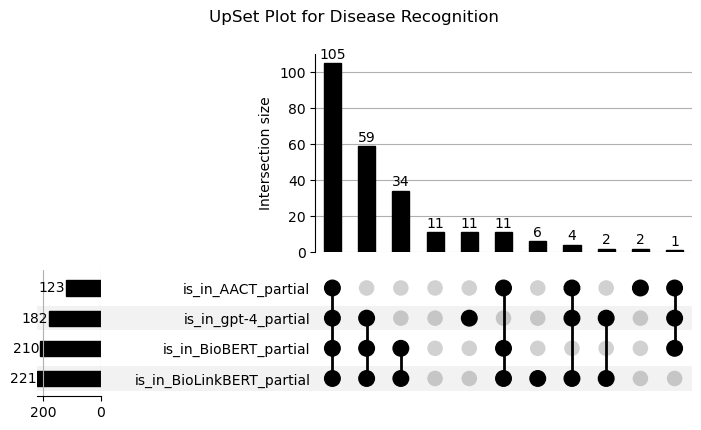

In [118]:
# NOTE: does not show false positives
plot(df_up, orientation='horizontal', show_counts=True, sort_by='cardinality') #, 'degree'}
plt.suptitle("UpSet Plot for Disease Recognition")

## Drugs

In [134]:
df_drugs

,Unnamed: 0,nct_id,canonical_unique_interventions,canonical_bert-base-uncased_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_gpt-4_interventions,canonical_aact_interventions,eval_exact_match_bert-base-uncased,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,0,NCT04849741,ion373,ion373,ion373,ion373,ion373,ion373,ion373,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
1,1,NCT04576507,dronabinol|cannabinoids|dronabinol|cannabidiol...,cannabidiol|cannabinoids|dronabinol,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis,"{'p': 1.0, 'r': 0.75, 'f1': 0.86}",...,"{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.6, 'r': 0.75, 'f1': 0.67}","{'tp': 3, 'fp': 2, 'fn': 1}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}"
2,2,NCT00261508,antipsychotic medication|risperidone,risperidon|anti|risperidone,antipsychotic medication|risperidone,antipsy,risperidone|placebo,risperidone,risperidone,"{'p': 0.33, 'r': 0.5, 'f1': 0.4}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
3,3,NCT01495923,gabapentin|steroid,epid|gabapentin|steroid,gabapentin,gabapentin,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin,gabapentin|gabapentin|sham epidural steroid in...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}",...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}"
4,4,NCT03150563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,NCT03755362,NaN,NaN,NaN,NaN,periodontitis,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
86,86,NCT00506415,rivastigmine|rivastigmine patch|rivastigmine,rivastigmine|rivastigmine patch|rivastigmine,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,rivastigmine patch|rivastigmine|rivastigmine p...,exelon®|rivastigmine patch,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.5, 'r': 0.5

In [135]:
df_to_eval = df_drugs[['nct_id','canonical_unique_interventions', 'canonical_aact_interventions', 'canonical_BioLinkBERT-base_interventions', 'canonical_biobert-v1.1_interventions','canonical_gpt-4_interventions']]

# Split the first column by '|'
df_to_eval['canonical_unique_interventions'] = df_to_eval['canonical_unique_interventions'].str.split('|')

# Explode the DataFrame based on the first column
df_exploded = df_to_eval.explode('canonical_unique_interventions')
df_exploded = df_exploded.dropna(subset=['canonical_unique_interventions'])

df_exploded

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_77952/118845940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_eval['canonical_unique_interventions'] = df_to_eval['canonical_unique_interventions'].str.split('|')


,nct_id,canonical_unique_interventions,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt-4_interventions
0,NCT04849741,ion373,ion373,ion373,ion373,ion373
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
1,NCT04576507,cannabinoids,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
1,NCT04576507,cannabidiol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
...,...,...,...,...,...,...
84,NCT00120588,magnesium sulfate,magnesium,magnesium|magnesium sulfate,magnesium|magnesium sulfate,magnesium sulfate
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch
86,NCT00506415,rivastigmine patch,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch


In [137]:
df_exploded['is_in_AACT_partial'] = df_exploded.apply(check_partial_match, column='canonical_aact_interventions', target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioLinkBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_BioLinkBERT-base_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_biobert-v1.1_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_gpt-4_partial'] = df_exploded.apply(check_partial_match, column='canonical_gpt-4_interventions',target_col='canonical_unique_interventions', axis=1)

# Apply the function to create new columns
df_exploded['is_in_AACT'] = df_exploded.apply(check_match, column='canonical_aact_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioBERT'] = df_exploded.apply(check_match, column='canonical_biobert-v1.1_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_gpt-4'] = df_exploded.apply(check_match, column='canonical_gpt-4_interventions',target_col='canonical_unique_interventions', axis=1)

df_exploded

,nct_id,canonical_unique_interventions,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt-4_interventions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
0,NCT04849741,ion373,ion373,ion373,ion373,ion373,True,True,True,True,True,True,True,True
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,False,False,False,False,False,False,False
1,NCT04576507,cannabinoids,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,True,False,False,False,True,False,False
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,False,False,False,False,False,False,False
1,NCT04576507,cannabidiol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,NCT00120588,magnesium sulfate,magnesium,magnesium|magnesium sulfate,magnesium|magnesium sulfate,magnesium sulfate,True,True,True,True,False,True,True,True
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch,True,True,True,True,False,True,True,False
86,NCT00506415,rivastigmine patch,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch,True,True,True,True,False,True,False,True
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch,True,True,True,True,False,True,True,False


In [143]:
df_exploded.to_csv("./evaluations/upset_plot_check_drugs.csv")

### Plot

In [147]:
set_names = ['is_in_AACT_partial', 'is_in_BioLinkBERT_partial', 'is_in_BioBERT_partial', 'is_in_gpt-4_partial']
#set_names = ['is_in_AACT', 'is_in_BioLinkBERT', 'is_in_BioBERT', 'is_in_gpt-4']

df = df_exploded[set_names]
df_up = df.groupby(set_names).size()
df_up

is_in_AACT_partial  is_in_BioLinkBERT_partial  is_in_BioBERT_partial  is_in_gpt-4_partial
False               False                      False                  False                   6
                                                                      True                    1
                                               True                   False                   1
                                                                      True                    1
                    True                       False                  False                   3
                                                                      True                    1
                                               True                   False                   5
                                                                      True                    8
True                False                      False                  True                    1
                    True                      

Text(0.5, 0.98, 'UpSet Plot for Drug Recognition')

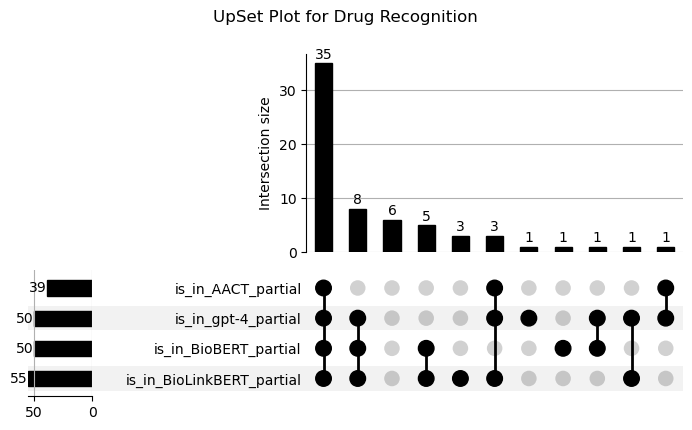

In [148]:
plot(df_up, orientation='horizontal', show_counts=True, sort_by='cardinality') #, 'degree'}
plt.suptitle("UpSet Plot for Drug Recognition")

In [151]:
set_names

['is_in_AACT_partial',
 'is_in_BioLinkBERT_partial',
 'is_in_BioBERT_partial',
 'is_in_gpt-4_partial']

In [153]:
# List of column names to check, excluding 'is_in_gpt-4'
model_to_review = 'is_in_gpt-4_partial'
set_names_review = set_names.copy()
set_names_review.remove(model_to_review)

# Filter DataFrame
filtered_df = df_exploded[(df_exploded[set_names_review] == False).all(axis=1) & (df_exploded[model_to_review] == True)]
print(len(filtered_df))
filtered_df

1


,nct_id,canonical_unique_interventions,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt-4_interventions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
89,NCT03540602,polyphenol,NaN,NaN,NaN,polyphenol rich supplementation,False,False,False,True,False,False,False,False


In [157]:
target_words = ["polyphenol"]
prediction_words = "polyphenol rich supplementation".split()
print(target_words, prediction_words)
#print(target_words, prediction_words)
common_words = set(target_words) & set(prediction_words)
#print(common_words)
# Check if more than half of the target words overlap
if len(common_words) >= len(target_words) / 2:
    print("matching")

['polyphenol'] ['polyphenol', 'rich', 'supplementation']
matching
